In [1]:
!pip install pymatch
!pip install pandas==0.23.4

  Created wheel for pymatch: filename=pymatch-0.3.4-py3-none-any.whl size=9116 sha256=d8ffe2daea47a752e1c3a3381fb77f8d505db55ef0eea184d1d195c4a2bf8e5e
  Stored in directory: /root/.cache/pip/wheels/8c/fe/b6/2c7c881a82d7a037c2d0c4563a608c7fc0a8d7bf34b88ae00f
Successfully built pymatch
     |████████████████████████████████| 8.8 MB 4.4 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.18.2 requires pandas>=1.0, but you have pandas 0.23.4 which is incompatible.
pymc3 3.11.4 requires pandas>=0.24.0, but you have pandas 0.23.4 which is incompatible.
plotnine 0.6.0 requires pandas>=0.25.0, but you have pandas 0.23.4 which is incompatible.
mizani 0.6.0 requires pandas>=0.25.0, but you have pandas 0.23.4 wh

In [7]:
import pandas as pd
import numpy as np
from pymatch.Matcher import Matcher
from statsmodels.formula.api import ols

In [8]:
df = pd.read_csv('DiD_data.csv', header='infer', index_col=False)
df['rssd9999'] = pd.to_datetime(df['rssd9999'], format='%Y%m%d')

In [9]:
unique_bank = df['rssd9001'].unique()
unique_date = df['rssd9999'].unique()
date_before = df[df['rssd9999'] <= '2007-06-30']['rssd9999'].unique()
date_after = df[df['rssd9999'] > '2007-06-30']['rssd9999'].unique()

In [10]:
bank_dict = {'full': [], 'missing_before': [], 'missing_before_val' : [],  'missing_after': [], 'missing_after_val' : []}
for bank in unique_bank:
  full_set = df[df['rssd9001'] == bank]['rssd9999'].unique()
  opened_before = df[(df['rssd9001'] == bank) & (df['rssd9999'] <= '2007-06-30')]['rssd9999'].unique()
  opened_after = df[(df['rssd9001'] == bank) & (df['rssd9999'] > '2007-06-30')]['rssd9999'].unique()
  
  if set(full_set) == set(unique_date):
    bank_dict['full'].append(bank)
  
  elif set(opened_before) != set(date_before):
    bank_dict['missing_before'].append(bank)
    bank_dict['missing_before_val'].append(len(date_before) - len(opened_before))

  elif set(opened_after) != set(date_after):
    bank_dict['missing_after'].append(bank)
    bank_dict['missing_after_val'].append(len(date_after) - len(opened_after))

In [11]:
df.dropna(inplace=True)
df = df[df['rssd9001'].isin(bank_dict['full'])]

In [12]:
df_propensity = df[df['rssd9999'] == '2004-09-30']
df_propensity.columns
test = df_propensity[df_propensity.treat_3_b_avg == 1]
control = df_propensity[df_propensity.treat_3_b_avg == 0]
m = Matcher(test, control, yvar = 'treat_3_b_avg', exclude=['dep_roa1', 'dep_leverage', 'dep_lnassets', 'dep_depositratio','rssd9001', 'rssd9999', 'bhc_avgtradingratio', 'treat_3_b_avg', 'after_DFA_1', 'dep_creditrisk_total3', 'dep_cpp_bankquarter'])

Formula:
treat_3_b_avg ~ dep_cir+dep_loans_REratio+dep_liquidity
n majority: 540
n minority: 8


In [13]:
m.raise_on_perfect_prediction = False

In [14]:
m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 1\100

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Fitting Models on Balanced Samples: 2\100

/usr/local/lib/python3.7/dist-packages/pymatch/Matcher.py:103: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  uf.drop_static_cols(df[df[self.yvar] == 0], yvar=self.yvar)])


Fitting Models on Balanced Samples: 81\100

/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


Fitting Models on Balanced Samples: 100\100
Average Accuracy: 81.25%


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


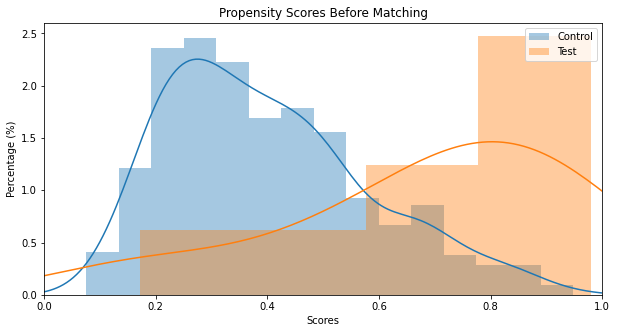

In [15]:
m.predict_scores()
m.plot_scores()

In [16]:
m.match(method="min", nmatches=3, threshold=0.0001)
m.record_frequency()
m.assign_weight_vector()

/usr/local/lib/python3.7/dist-packages/pymatch/Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['match_id'] = match_ids
/usr/local/lib/python3.7/dist-packages/pymatch/Matcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['record_id'] = self.matched_data.index


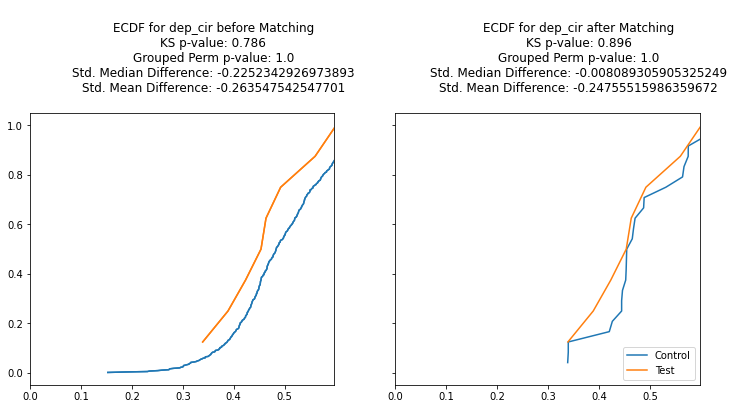

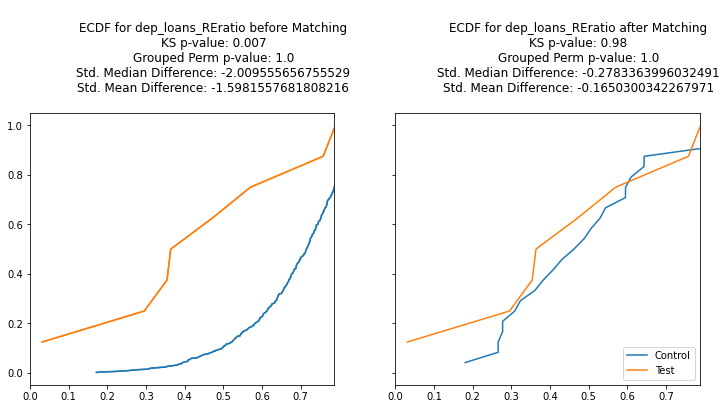

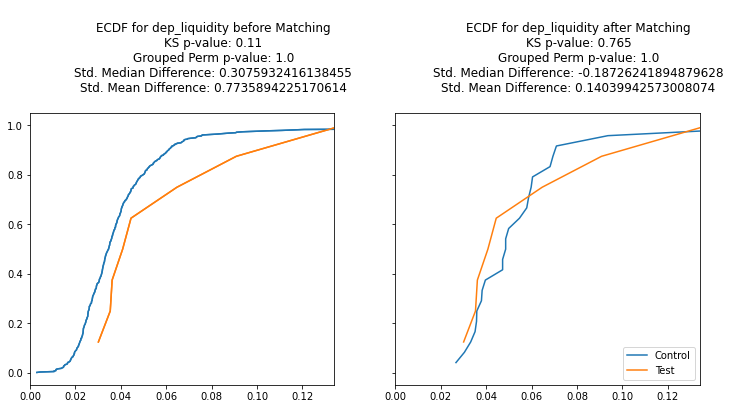

In [18]:
cc = m.compare_continuous(return_table=True)

In [ ]:
df_propensity_matched = m.matched_data
df_propensity_matched.to_csv('./data_propensity_matched.csv')